In [2]:
from itertools import combinations

import numpy as np
import numpy.typing as npt

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from scipy.spatial import ConvexHull
from scipy.linalg import null_space

from typing import List

from spectra import Spectra
from models import gaussian
from metamers import Cone, Observer

from scipy.spatial.distance import cdist

import csv


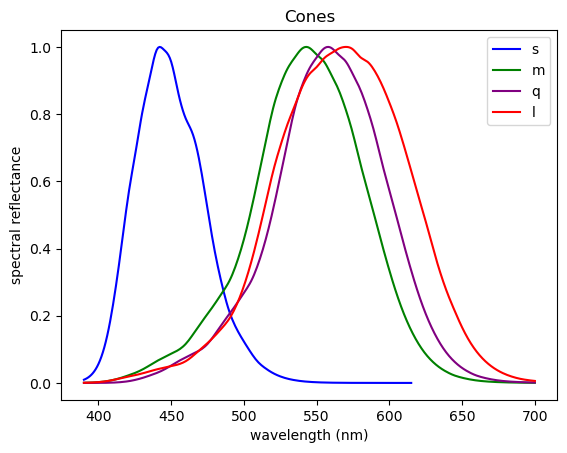

In [3]:
def remove_trailing_nans(arr):
    mask = np.any(np.isnan(arr), axis=1)
    idx = np.where(mask)[0]
    if idx.size > 0:
        last_valid_idx = np.where(~mask)[0][-1]
        return arr[:last_valid_idx + 1]
    return arr

cone_data = np.genfromtxt('linss2_10e_1.csv', delimiter=',')

l_cone = Cone(cone_data[:311, [0, 1]])
m_cone = Cone(cone_data[:311, [0, 2]])
s_cone = Cone(remove_trailing_nans(cone_data[:311, [0, 3]]))



shift = 15
r = [(w,1e-4) for w in m_cone.wavelengths() if w < m_cone.wavelengths()[0]+shift] + \
        [(w+shift,v) for (w,v) in m_cone.reflectance if w+shift <= m_cone.wavelengths()[-1]]
q_cone = Cone(reflectance=np.array(r))

#q_cone = Cone(wavelengths=l_cone.wavelengths(), data=gaussian(l_cone.wavelengths(), 1, 555, 40))

s_cone.plot(name="s", color="b")
m_cone.plot(name="m", color="g")
q_cone.plot(name='q', color='purple')
l_cone.plot(name="l", color="r")
plt.xlabel('wavelength (nm)')
plt.ylabel('spectral reflectance')
plt.title('Cones')
plt.legend()
plt.show()

In [4]:
tetrachromat = Observer([s_cone, m_cone, q_cone, l_cone], min_transition_size=10)

In [5]:
tetrachromat_cones = np.vstack((tetrachromat.wavelengths.T, tetrachromat.sensor_matrix))
tetrachromat_cones.shape

(5, 311)

In [6]:
np.save("tetrachromat_cones.npy", tetrachromat_cones)

In [7]:
TETRA_GAMUT_POINTS = tetrachromat.get_full_colors().T
TETRA_GAMUT_POINTS.shape
np.save("tetra_gamut_points.npy", TETRA_GAMUT_POINTS)

In [8]:
def intersects_plane(o, d, v0, v1, v2, eps=1e-6):
    no_soln = False, None, (None, None)
    matrix = np.column_stack((v0 - v1, v0 - v2))
    normals = null_space(matrix.T)
    if normals.shape[1] != 2:
        # degen
        return no_soln
    print(normals[:,0].shape)
    

    denom1 = np.dot(normals[:, 0].T, d)
    denom2 = np.dot(normals[:, 1].T, d)
    print(eps)
    print(np.abs(denom1) < eps)
    print(np.abs(denom2) < eps)

    if np.abs(denom1) < eps or np.abs(denom2) < eps:
        return no_soln

    t1 = np.dot(normals[:, 0].T, v0 - o) / denom1
    t2 = np.dot(normals[:, 1].T, v0 - o) / denom2
    
    print(t1,t2)
    if t1 > 0 and t2 > 0:
        print(t1, t2)

    if np.abs(t1 - t2) < eps and t1 > 0 and t2 > 0:
        intersection_point = o + t1 * d
        return True, intersection_point, (t1, t2)

    return no_soln

def is_point_in_triangle(p, v0, v1, v2, eps=1e-6):
    v0v1 = v1 - v0
    v0v2 = v2 - v0
    p_v0 = p - v0
    dot00 = np.dot(v0v2, v0v2)
    dot01 = np.dot(v0v2, v0v1)
    dot02 = np.dot(v0v2, p_v0)
    dot11 = np.dot(v0v1, v0v1)
    dot12 = np.dot(v0v1, p_v0)
    inv_denom = 1 / (dot00 * dot11 - dot01 * dot01)
    u = (dot11 * dot02 - dot01 * dot12) * inv_denom
    v = (dot00 * dot12 - dot01 * dot02) * inv_denom
    return (u >= -eps) and (v >= -eps) and (u + v <= 1 + eps)

def intersects_triangle(o, d, v0, v1, v2, eps=1e-6):
    print(eps)
    success, intersection_point, (t1, t2) = intersects_plane(o, d, v0, v1, v2, eps)
    if success and is_point_in_triangle(intersection_point, v0, v1, v2, eps):
        return True, t1  # or return True, t2 since they are very close
    return False, None

# def intersects_hull(o, d, points):
    
#     hull = ConvexHull(points)
#     intersection_indices = []
    
#     for simplex in hull.simplices:
#         vertices = [points[idx] for idx in simplex]
#         print(np.array(vertices).shape)
#         hit, t = intersects_triangle(o, d, *vertices)
#         if hit:
#             distances = [np.linalg.norm((o + t *d) - v) for v in vertices]
            
#             closest_idx = np.argmin(distances)
#             closest_vertex_idx = simplex[closest_idx]
#             intersection_indices.append(closest_vertex_idx)
#     return intersection_indices



In [20]:
color_file_dict = {
    "": "000",
    "c": "100",
    "m": "010",
    "y": "001",
    "cm": "110",
    "cy": "101",
    "my": "011",
    "cmy": "111"
}

color_spectra_dict = {}
wavelengths = np.arange(400, 701, 10)
\

for color, fn in color_file_dict.items():
    with open(f'PrintColors/{fn}.csv') as csvf:
        spamreader = csv.reader(csvf, delimiter=';')
        for i, row in enumerate(spamreader):
            if i == 4:
                color_data = np.array(row[33:],dtype=float)
                spectra = Spectra(data=color_data, wavelengths=wavelengths)
                color_spectra_dict[fn] = spectra


def neugebauer_mix(percentages, n=1.8):
    # Yule-Nielsen modifications
    # modified_percentages = percentages**n / (percentages**n + (1 - percentages)**n)
    percentages = np.array(percentages, dtype=float)
    output = Spectra(wavelengths=wavelengths, data=np.zeros_like(wavelengths))
    for key, spectra in color_spectra_dict.items():
        binary_vector = np.array(list(map(int, key)))
        weight = np.prod(binary_vector * percentages + (1 - binary_vector) * (1 - percentages))
        output += weight * (spectra ** (1 / n))
    return (output ** n)


In [28]:
neugebauer_mix((0,0,0)).wavelengths()

array([400., 410., 420., 430., 440., 450., 460., 470., 480., 490., 500.,
       510., 520., 530., 540., 550., 560., 570., 580., 590., 600., 610.,
       620., 630., 640., 650., 660., 670., 680., 690., 700.])

In [25]:
_ink_gamut_points = []
_ink_spectra_points = []

# put c, m, y at start for convenience
_ink_gamut_points.extend(
    [tetrachromat.observe(spectra) for spectra in [color_spectra_dict["100"],
                                                color_spectra_dict["010"],
                                                color_spectra_dict["001"]]]
)

for c in np.arange(0, 1.1, 0.1):
    for m in np.arange(0, 1.1, 0.1):
        for y in np.arange(0, 1.1, 0.1):
            mixed_spectra = neugebauer_mix(np.array((c,m,y)))
            quadstimulus = tetrachromat.observe(mixed_spectra)
            _ink_gamut_points.append(quadstimulus)
            _ink_spectra_points.append(mixed_spectra.data())

INK_GAMUT_POINTS = np.array(_ink_gamut_points)
INK_SPECTRA_POINTS = np.array(_ink_spectra_points)

In [27]:
print(INK_SPECTRA_POINTS.shape)
np.save("ink_spectra_points.npy", INK_SPECTRA_POINTS)

(1331, 31)


In [32]:
INK_GAMUT_POINTS.shape

(1334, 4)

In [33]:
np.save("tetrachromat_ink_gamut.npy", INK_GAMUT_POINTS)

In [30]:
print(INK_GAMUT_POINTS.shape)

(1334, 4)


**Dimension analysis**

In [ ]:
def plot_pointcloud_hull(points, labels=('S','M','L'), fig=None, ax=None, alpha=1):
    # points in shape M x 3
    hull = ConvexHull(points)
    
    if fig is None or ax is None:  
        fig = plt.figure()
        ax = fig.add_subplot(111, projection="3d")
    ax.set_xlabel(labels[0])
    ax.set_ylabel(labels[1])
    ax.set_zlabel(labels[2])    
    
    
    for simplex in hull.simplices:
        s = simplex.astype(int)
        s = np.append(s, s[0]) 
        ax.plot(points[s,0], points[s,1], points[s,2], "k-", alpha=alpha)
        
            

    return fig, ax

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca_result = pca.fit_transform(INK_GAMUT_POINTS)
print(pca.components_)

In [ ]:
%matplotlib notebook
fig, ax = plot_pointcloud_hull(pca_result, labels=['p1', 'p2', 'p3'], alpha=0.4)
ax.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2], alpha=0.1)
ax.scatter(pca_result[:3, 0], pca_result[:3, 1], pca_result[:3, 2], c=["cyan", "magenta", "yellow"], marker='d')


In [ ]:
pca2d = PCA(n_components=2)
pca_result2d  = pca2d.fit_transform(INK_GAMUT_POINTS)

fig_pca, ax_pca = plt.subplots()
ax_pca.scatter(pca_result2d[:, 0], pca_result2d[:, 1], alpha=0.3)
ax_pca.scatter(pca_result2d[:3, 0], pca_result2d[:3, 1], c=["cyan", "magenta", "yellow"], marker='d')

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3, perplexity=30, n_iter=300)
tsne_result = tsne.fit_transform(INK_GAMUT_POINTS)

In [ ]:
fig2, ax2 = plot_pointcloud_hull(tsne_result, labels=['t1', 't2', 't3'], alpha=0.4)
ax2.scatter(tsne_result[:, 0], tsne_result[:, 1], tsne_result[:, 2], alpha=0.1)
ax2.scatter(tsne_result[:3, 0], tsne_result[:3, 1], tsne_result[:3, 2], c=["cyan", "magenta", "yellow"], marker='d')

In [ ]:
from sklearn.manifold import TSNE

tsne2d = TSNE(n_components=2, perplexity=30, n_iter=300)
tsne_result2d = tsne2d.fit_transform(INK_GAMUT_POINTS)

fig2d, ax2d = plt.subplots()

ax2d.scatter(tsne_result2d[:, 0], tsne_result2d[:, 1], s=10, alpha=0.3)

ax2d.scatter(tsne_result2d[:3, 0], tsne_result2d[:3, 1], c=["cyan", "magenta", "yellow"], marker='d')

¡que sublime!

In [ ]:
count = 0
sorted_points = INK_GAMUT_POINTS[INK_GAMUT_POINTS[:,2].argsort()]
for i in range(1, len(sorted_points)):
    diff = np.min(np.abs(sorted_points[i, [1, 2, 3]] - sorted_points[i-1, [1, 2, 3]]))
    if abs(sorted_points[i, 0] - sorted_points[i-1, 0]) < diff:
        count += 1
        #print(sorted_points[i], sorted_points[i-1])
print(count)

In [ ]:
count = 0
sorted_points = INK_GAMUT_POINTS[INK_GAMUT_POINTS[:,2].argsort()]
for i in range(1, len(sorted_points)):
    diff = np.min(np.abs(sorted_points[i, [0, 2, 3]] - sorted_points[i-1, [0, 2, 3]]))
    if abs(sorted_points[i, 1] - sorted_points[i-1, 1]) < diff:
        count += 1
        #print(sorted_points[i], sorted_points[i-1])
print(count)

In [ ]:
count = 0
sorted_points = INK_GAMUT_POINTS[INK_GAMUT_POINTS[:,2].argsort()]
for i in range(1, len(sorted_points)):
    diff = np.min(np.abs(sorted_points[i, [0, 1, 3]] - sorted_points[i-1, [0, 1, 3]]))
    if abs(sorted_points[i, 2] - sorted_points[i-1, 2]) < diff:
        count += 1
        #print(sorted_points[i], sorted_points[i-1])
print(count)

In [ ]:
count = 0
sorted_points = INK_GAMUT_POINTS[INK_GAMUT_POINTS[:,2].argsort()]
for i in range(1, len(sorted_points)):
    diff = np.min(np.abs(sorted_points[i, [0, 1, 2]] - sorted_points[i-1, [0, 1, 2]]))
    if abs(sorted_points[i, 3] - sorted_points[i-1, 3]) < diff:
        count += 1
        #print(sorted_points[i], sorted_points[i-1])
print(count)

In [ ]:
39 + 1262 + 27 + 2

"woh"

In [ ]:
count = 0
sorted_points = INK_GAMUT_POINTS[INK_GAMUT_POINTS[:,2].argsort()]
for i in range(1, len(sorted_points)):
    diff = np.max(np.abs(sorted_points[i, [0, 1, 3]] - sorted_points[i-1, [0, 1, 3]]))
    if abs(sorted_points[i, 2] - sorted_points[i-1, 2]) > diff:
        count += 1
        #print(sorted_points[i], sorted_points[i-1])
print(count)

this indicates that the gamut is *extremely* flat along the Q axis. Definitely no metamers here.

In [ ]:
from collections import defaultdict
buckets = defaultdict(list)

for (s, m, q, l) in INK_GAMUT_POINTS:
    key = (int(10 * s), int(10 * m), int(10 * l))
    buckets[key].append(q)
    
max_qs = -1
max_key = None
count = 0
for key, qs in buckets.items():
    count += 1
    max_dist = max(qs) - min(qs)
    if max_dist > max_qs:
        max_qs = max_dist
        max_key = key
    
print(max_key, max_qs)

In [ ]:
print(buckets[(3,2,2)])

Result confirms that the max distance between Q values is basically less than the max distance between L, M, S values always.

**more dimension analysis attempts**
1. umap (library is broken but want to get working in a new conda env)
2. hull intersection (its hard in 4d and also hulls arent quite the right approach for a variety of reasons -- only a decent approach when we know the shape is definitely 4d (which it isn't!)

In [ ]:
import umap

umap_transformer = umap.UMAP(n_neighbors=15, n_components=3, metric='euclidean', random_state=42)

# Fit the transformer and transform the data
ink_gamut_umap = umap_transformer.fit_transform(INK_GAMUT_POINTS)

# Plot the resulting 3D projection
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(ink_gamut_umap[:, 0], ink_gamut_umap[:, 1], ink_gamut_umap[:, 2], s=5)
plt.show()


motherfucking triangle intersection doesnt work in four dimensions

In [ ]:
def intersects_hull(o, d, points):
    hull = ConvexHull(points)
    
    eq=hull.equations.T
    V,b=eq[:-1].T,eq[-1]
    
    t = (-b - np.dot(V, o)) / np.dot(V, d)
    
    return 0.295 * d + o # np.min(t[t>0])*d + o 

In [ ]:
what the fuck 
whatth efuck 

In [ ]:
o = np.array([0.4, 0.3, 0, 0.3])
a = intersects_hull(o,d, INK_GAMUT_POINTS)
txprint(a)

hull = ConvexHull(INK_GAMUT_POINTS)

eq=hull.equations.T
V,b=eq[:-1].T,eq[-1]

np.sum(np.dot(V, a) + b <= 0)

d = np.array([0,0,1,0])

for x0 in np.arange(0, 1, 0.1):
    for x1 in np.arange(0, 1, 0.1):
        for x3 in np.arange(0, 1, 0.1):
            o = np.array([x0, x1, 0, x3])
            a = intersects_hull(o, d, INK_GAMUT_POINTS)
            if a:
                print(a)

In [ ]:
ConvexHull(INK_GAMUT_POINTS).equations.shape

In [ ]:
ConvexHull(INK_GAMUT_POINTS).simplices.shape